## Setup

<font color='red'>**Warning**: if you work on Colab, upload the data zip on Google Drive in order to not have to upload it on your environment every time. It's also much faster to upload files on Google Drive than on Colab.</font>

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Make sure to change path if you put the zip elsewhere
!unzip drive/MyDrive/chest_xray.zip

Streaming output truncated to the last 5000 lines.
  inflating: chest_xray/train/pneumonia/person1608_bacteria_4235.jpeg  
  inflating: chest_xray/train/pneumonia/person445_virus_916.jpeg  
  inflating: chest_xray/train/pneumonia/person302_bacteria_1430.jpeg  
  inflating: chest_xray/train/pneumonia/person1188_bacteria_3137.jpeg  
  inflating: chest_xray/train/pneumonia/person353_virus_728.jpeg  
  inflating: chest_xray/train/pneumonia/person348_bacteria_1602.jpeg  
  inflating: chest_xray/train/pneumonia/person1272_bacteria_3232.jpeg  
  inflating: chest_xray/train/pneumonia/person1294_virus_2222.jpeg  
  inflating: chest_xray/train/pneumonia/person3_bacteria_12.jpeg  
  inflating: chest_xray/train/pneumonia/person124_virus_234.jpeg  
  inflating: chest_xray/train/pneumonia/person378_virus_761.jpeg  
  inflating: chest_xray/train/pneumonia/person1478_bacteria_3848.jpeg  
  inflating: chest_xray/train/pneumonia/person1446_bacteria_3740.jpeg  
  inflating: chest_xray/train/pneumonia/per

## Create dataset from directory

In [5]:
import tensorflow as tf
from pathlib import Path

# Define constants for image size and batch size
IMG_WIDTH = IMG_HEIGHT = 128
BATCH_SIZE = 64

# Define the paths to the training, validation, and testing datasets
base_dir = Path('chest_xray')  # Base directory for the dataset
train_dir = base_dir / 'train'
val_dir = base_dir / 'val'
test_dir = base_dir / 'test'

# Check if the directories exist
if not (train_dir.exists() and val_dir.exists() and test_dir.exists()):
    raise FileNotFoundError("One or more dataset directories are missing. Ensure you have unzipped the dataset and the structure is correct.")

# Load the training dataset
train_ds = tf.keras.utils.image_dataset_from_directory(
    train_dir,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_names=['normal', 'pneumonia'],  # Class names for the dataset
    label_mode='binary',  # Binary classification
    color_mode='grayscale',  # Grayscale images
)

# Load the validation dataset
val_ds = tf.keras.utils.image_dataset_from_directory(
    val_dir,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_names=['normal', 'pneumonia'],
    label_mode='binary',
    color_mode='grayscale',
)

# Load the testing dataset
test_ds = tf.keras.utils.image_dataset_from_directory(
    test_dir,
    image_size=(IMG_HEIGHT, IMG_WIDTH),
    batch_size=BATCH_SIZE,
    class_names=['normal', 'pneumonia'],
    label_mode='binary',
    color_mode='grayscale',
)


Found 5216 files belonging to 2 classes.
Found 16 files belonging to 2 classes.
Found 624 files belonging to 2 classes.


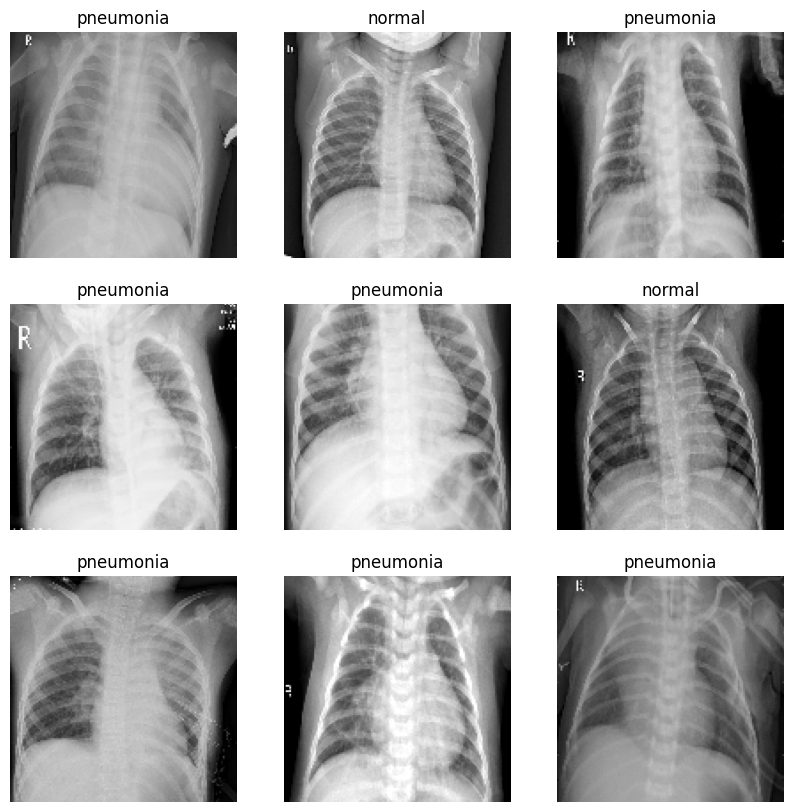

In [6]:
import matplotlib.pyplot as plt

# Extract a batch of images and labels from the training dataset
for images, labels in train_ds.take(1):
    plt.figure(figsize=(10, 10))

    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().squeeze(), cmap='gray')
        plt.title(f'{train_ds.class_names[int(labels[i])]}')
        plt.axis('off')

    plt.show()

## Compute class weights

In [7]:
import numpy as np

# Initialize class counts
class_counts = np.zeros(len(train_ds.class_names), dtype=np.int64)

# Iterate over the dataset to count samples in each class
for images, labels in train_ds:
    flattened_labels = tf.cast(labels, dtype=tf.int64)  # Cast labels to int64
    flattened_labels = tf.reshape(flattened_labels, [-1])  # Flatten the labels
    class_counts += np.bincount(flattened_labels.numpy(), minlength=len(train_ds.class_names))

# Compute total number of samples
total_samples = np.sum(class_counts)

# Compute class weights
num_classes = len(train_ds.class_names)
class_weights = {i: total_samples / (num_classes * count) for i, count in enumerate(class_counts)}

In [11]:
class_weights

{0: 1.9448173005219984, 1: 0.6730322580645162}

## Create CNN model

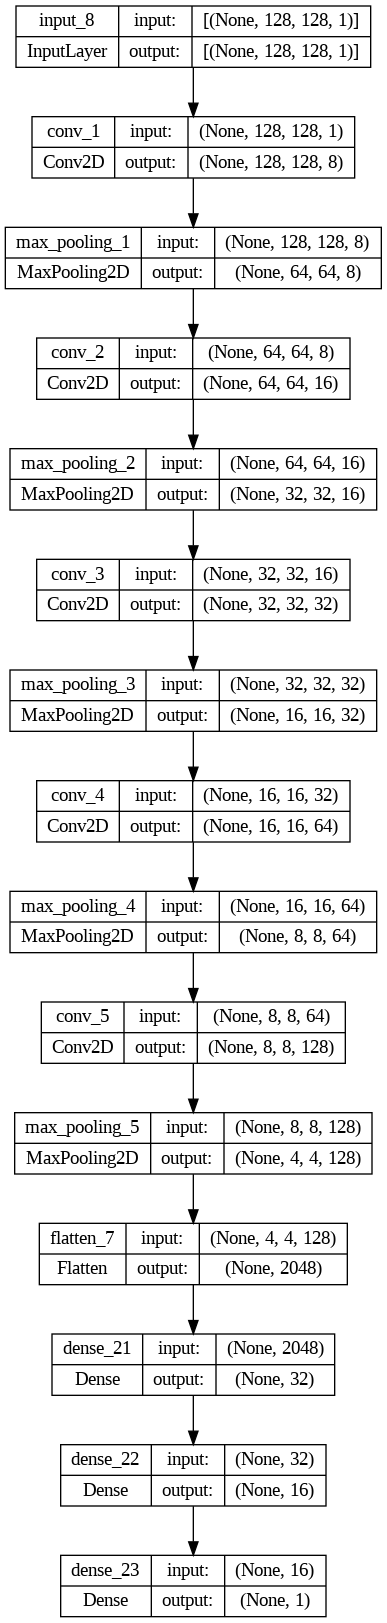

In [42]:
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

from tensorflow.keras import (
    layers,
    activations,
    Model,
    optimizers,
    losses
)

# Define CNN model
input = layers.Input((IMG_HEIGHT, IMG_WIDTH, 1))

# TODO: Complete this in order to have the same architecture
# as the one represented in the cell above
# note: use convolutions with relu and kernel size of 3.

conv1 = Conv2D(8, (3, 3), padding="same", activation="relu", name="conv_1")(input)

max_pooling_1 = MaxPooling2D(pool_size=(2, 2), name="max_pooling1")(conv1)

conv_2 = Conv2D(16, (3, 3), padding="same", activation="relu", name="conv_2")(max_pooling_1)

max_pooling_2 = MaxPooling2D(pool_size=(2, 2), name="max_pooling_2")(conv_2)

conv3 = Conv2D(32, (3, 3), padding="same", activation="relu", name="conv_3")(max_pooling_2)

max_pooling_3 = MaxPooling2D(pool_size=(2, 2), name="max_pooling_3")(conv3)

conv4 = Conv2D(64, (3, 3), padding="same", activation="relu", name="conv_4")(max_pooling_3)

#-----------------------

max_pooling_4 = MaxPooling2D(pool_size=(2, 2), name="max_pooling_4")(conv4)

conv5 = Conv2D(128, (3, 3), padding="same", activation="relu", name="conv_5")(max_pooling_4)

max_pooling_5 = MaxPooling2D(pool_size=(2, 2), name="max_pooling_5")(conv5)

flatten7 = Flatten(name="flatten7")(max_pooling_5)

dense_21 = Dense(32, activation="relu", name="dense_21")(flatten7)

dense_22 = Dense(16, activation="relu", name="dense_22")(dense_21)

cnn_output = Dense(1, activation="sigmoid", name="dense_23")(dense_22)

cnn = Model(inputs=input, outputs=cnn_output)

# Compile CNN model
cnn.compile(optimizer=optimizers.Adam(0.001), loss=losses.BinaryCrossentropy(), metrics=['accuracy'])

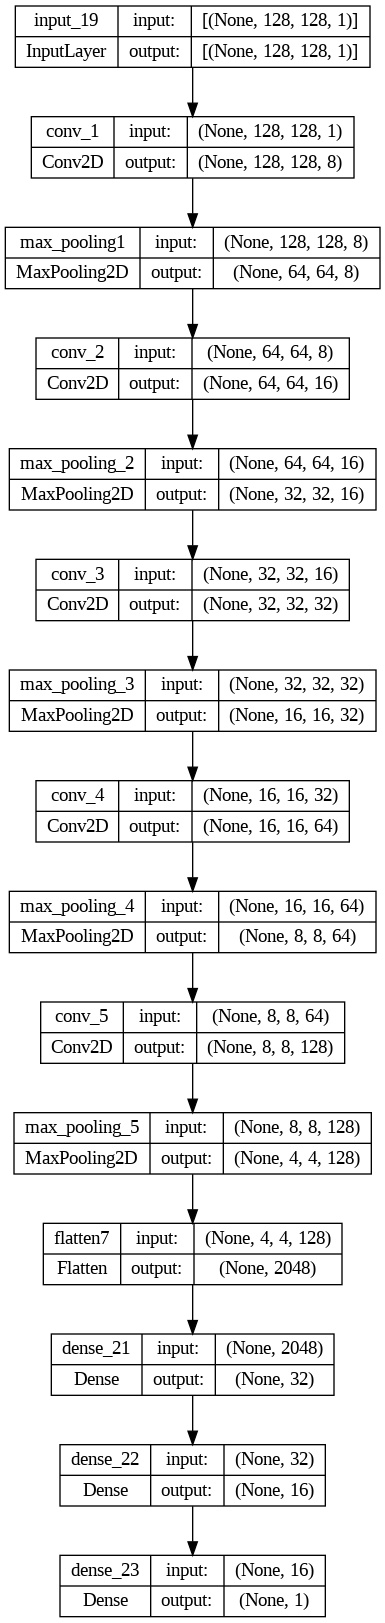

In [43]:
from tensorflow.keras.utils import plot_model

# Plot the model architecture
plot_model(cnn, show_shapes=True, show_layer_names=True)

In [58]:
history = cnn.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10,
    class_weight=class_weights
)

Epoch 1/10
82/82 [==============================] - 81s 903ms/step - loss: 0.0117 - accuracy: 0.9962 - val_loss: 0.1116 - val_accuracy: 0.9375
Epoch 2/10
82/82 [==============================] - 76s 892ms/step - loss: 0.0240 - accuracy: 0.9914 - val_loss: 0.0016 - val_accuracy: 1.0000
Epoch 3/10
82/82 [==============================] - 78s 892ms/step - loss: 0.0242 - accuracy: 0.9896 - val_loss: 0.5556 - val_accuracy: 0.8125
Epoch 4/10
82/82 [==============================] - 75s 884ms/step - loss: 0.0827 - accuracy: 0.9668 - val_loss: 0.1320 - val_accuracy: 0.9375
Epoch 5/10
82/82 [==============================] - 74s 869ms/step - loss: 0.0280 - accuracy: 0.9906 - val_loss: 0.1065 - val_accuracy: 0.9375
Epoch 6/10
82/82 [==============================] - 76s 887ms/step - loss: 0.0185 - accuracy: 0.9927 - val_loss: 0.0648 - val_accuracy: 1.0000
Epoch 7/10
82/82 [==============================] - 76s 894ms/step - loss: 0.0050 - accuracy: 0.9988 - val_loss: 0.1351 - val_accuracy: 0.9375

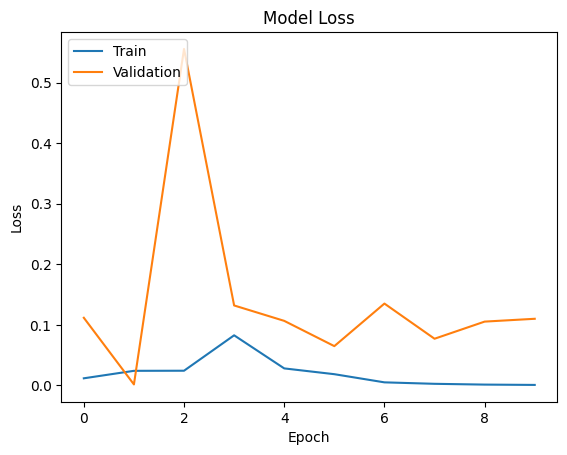

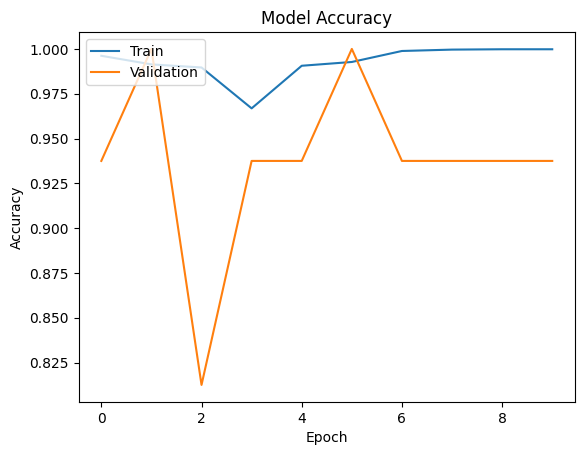

In [59]:
# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

10/10 [==============================] - 5s 167ms/step


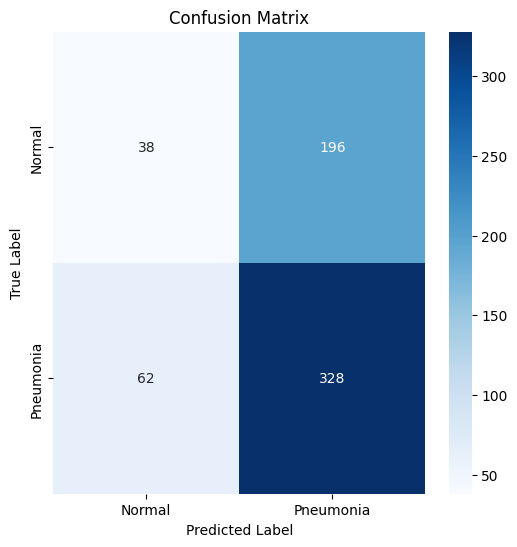

Accuracy: 0.5865384615384616
Precision: 0.6259541984732825
Recall: 0.841025641025641
F1 Score: 0.7177242888402625


In [60]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score
import seaborn as sns

val_images = []
val_labels = []

for img, label in val_ds:
  val_images.append(img)
  val_labels.append(label)

val_images = np.vstack(val_images)
val_labels = np.vstack(val_labels).squeeze().astype(int)

# TODO: create confusion matrix and compute metrics here
# and do the same for test set
pred = cnn.predict(test_ds)
predictions_binary = (pred > 0.75).astype(int)



test_labels = []
for _, label in test_ds:
    test_labels.append(label)

test_labels = np.vstack(test_labels).squeeze().astype(int)

conf_matrix = confusion_matrix(test_labels, predictions_binary)


plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=['Normal', 'Pneumonia'], yticklabels=['Normal', 'Pneumonia'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()



accuracy = accuracy_score(test_labels, predictions_binary)
precision = precision_score(test_labels, predictions_binary)
recall = recall_score(test_labels, predictions_binary)
f1 = f1_score(test_labels, predictions_binary)

print("Accuracy:", accuracy)
print("Precision:", precision)
print("Recall:", recall)
print("F1 Score:", f1)